# ADVANCED LEARNING FOR TEXT AND GRAPH DATA
## Lab session 6: Deep Learning for Graphs (2/2)
### Author : Romy BEAUTÉ

## 2 Graph Autoencoders

In [1]:
"""
ENCODER PART 
utils.py
"""

import scipy.sparse as sp
import numpy as np
import torch
import torch.nn as nn

def normalize_adjacency(A):
    ############## Task 1
    
    #################
    n = A.shape[0]

    A_with_self_loops = A + sp.identity(n)

    degrees = A_with_self_loops @ np.ones(n)
    inv_degrees = np.power(degrees,-1)
    D_inv = sp.diags(inv_degrees)

    A_normalized = D_inv @ A_with_self_loops
    ##################
    
    return A_normalized


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def loss_function(z, adj, device):
    mse_loss = nn.MSELoss()
    #sigmoid = nn.Sigmoid()
    sigmoid = nn.Sigmoid()
    ############## Task 3
    
    ##################
    y = list()
    y_pred = list()

    indices = adj._indices()
    m = indices.size(1)

    y.append(torch.ones(m).to(device))
    y_pred.append(sigmoid(torch.sum(torch.mul(z[indices[0],:],z[indices[1],:]),dim=1)))

    rand_indices = torch.randint(0,z.size(0),indices.size())
    y.append(torch.zeros(m).to(device))
    y_pred.append(sigmoid(torch.sum(torch.mul(z[rand_indices[0],:],z[rand_indices[1],:]),dim=1)))


    y = torch.cat(y, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    
    loss = mse_loss(y_pred,y)

    return loss




In [2]:
"""
models.py
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GAE(nn.Module):
    """GAE model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, dropout):
        super(GAE, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Task 2
    
        ##################
        x = self.fc1(x_in)
        h = self.relu(torch.mm(adj,x)) # first layer of the enccoder (only one hidden layer)
        h = self.dropout(h)

        z = self.fc2(h)
        z = torch.mm(adj,z)

        ##################

        return z

34
78
Epoch: 0001 loss_train: 0.2928 time: 0.1162s
Epoch: 0011 loss_train: 0.2238 time: 0.0011s
Epoch: 0021 loss_train: 0.2235 time: 0.0011s
Epoch: 0031 loss_train: 0.2075 time: 0.0011s
Epoch: 0041 loss_train: 0.1979 time: 0.0011s
Epoch: 0051 loss_train: 0.2039 time: 0.0012s
Epoch: 0061 loss_train: 0.1923 time: 0.0015s
Epoch: 0071 loss_train: 0.1913 time: 0.0011s
Epoch: 0081 loss_train: 0.1911 time: 0.0011s
Epoch: 0091 loss_train: 0.1876 time: 0.0011s
Epoch: 0101 loss_train: 0.1923 time: 0.0011s
Epoch: 0111 loss_train: 0.1724 time: 0.0011s
Epoch: 0121 loss_train: 0.1937 time: 0.0011s
Epoch: 0131 loss_train: 0.1841 time: 0.0011s
Epoch: 0141 loss_train: 0.1604 time: 0.0017s
Epoch: 0151 loss_train: 0.1519 time: 0.0023s
Epoch: 0161 loss_train: 0.1790 time: 0.0012s
Epoch: 0171 loss_train: 0.1769 time: 0.0011s
Epoch: 0181 loss_train: 0.1757 time: 0.0017s
Epoch: 0191 loss_train: 0.1491 time: 0.0012s


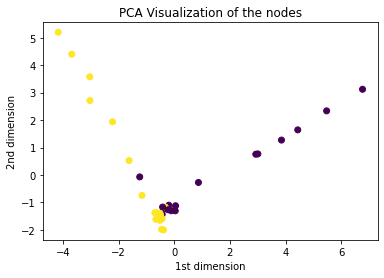

The homogeneity score of our clustering is  0.9410291937340104


In [4]:
"""
graph_autoencoder.py
"""

import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score

# from utils import normalize_adjacency, sparse_to_torch_sparse, loss_function
# from models import GAE


# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
n_hidden_1 = 16
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
# G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
G = nx.read_weighted_edgelist('karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())

print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

features = np.random.randn(n, 10) # Generates node features

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
adj = sparse_to_torch_sparse(adj).to(device)

# Creates the model and specifies the optimizer
model = GAE(features.shape[1], n_hidden_1, n_hidden_2, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    z = model(features, adj)
    loss = loss_function(z, adj, device)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss.item()),
              'time: {:.4f}s'.format(time.time() - t))


# Loads the class labels
# class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
class_labels = np.loadtxt('karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

############## Task 4
    
##################
embeddings = z.detach().cpu().numpy()

embeddings_2d = PCA(n_components=2).fit_transform(embeddings)
##################

# Visualizes the nodes
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=y)
plt.title('PCA Visualization of the nodes')
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.show()

############## Task 5
    
##################
km = KMeans().fit(embeddings)

print('The homogeneity score of our clustering is ',homogeneity_score(y,km.labels_)) #indicates pureness of the clusters
# Note that we obtain a very good homogeneity score, mearning that the communities are well clustered
##################


## 3 Graph Neural Networks for Graph-Level Tasks

### Gaph generation
Binary classification problem
50 graphs : G(n,p) with :  
- n = number of nodes in the graph we generate 
- p = probability that two nodes are connected by an edge (for each pair of nodes of the graph)


In [8]:
"""
utils.py (PART 2)
"""

import networkx as nx
import numpy as np
import torch
from random import randint

# use fast_gnp_random_graph()
# --> Returns a G_{n,p} random graph, also known as an Erdős-Rényi graph or a binomial graph.

def create_dataset():
    Gs = list()
    y = list()

    ############## Task 6
    
    ##################
    #Generate 50 graphs (ie 50 sampels) for each of the 2 classses
    for g in range(50): 
      Gs.append(nx.fast_gnp_random_graph(randint(10,20),0.2)) #0.2 : value for the first class
      y.append(0) #assign label 0 for the first class

      Gs.append(nx.fast_gnp_random_graph(randint(10,20),0.4)) #0.4 : value for the second class
      y.append(1) #assign label 1 to the second class

      #NB ==> class 1 will be more dense (higher probability to establish connexions between nodes)
    ##################

    return Gs, y


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


In [10]:
"""
models.py
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class, device):
        super(GNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):
        
        ############## Task 7
    
        ##################
        x = self.fc1(x_in)
        x = self.relu(torch.mm(adj,x))

        x = self.fc2(x)
        x = torch.mm(adj,x)

        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1)).to(self.device)
        out = out.scatter_add_(0, idx, x) 

        out = self.relu(self.fc3(out))
        out = self.fc4(out)
     
        ##################

        return F.log_softmax(out, dim=1)


In [12]:
"""
gnn.py
"""

import time
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim

# from models import GNN
# from utils import create_dataset, sparse_mx_to_torch_sparse_tensor

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    
    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        y_batch = list()

        ############## Task 8
        
        ##################
        for j in range(i, min(i+batch_size,N_train)):
          adj_batch.append(nx.adjacency_matrix(G_train[j]))
          idx_batch += [j-i]*G_train[j].number_of_nodes()

        adj_batch = sp.block_diag(adj_batch)
        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
        features_batch = np.ones((len(idx_batch),1)) #correspond to matrix (of features) x 
        features_batch = torch.FloatTensor(features_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.LongTensor(y_train[i:min(i+batch_size,N_train)]).to(device)
        ##################
        
        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
print('Optimization finished!')

# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0
for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    y_batch = list()

    ############## Task 8
    
    ##################
    for j in range(i, min(i+batch_size,N_test)):
      adj_batch.append(nx.adjacency_matrix(G_test[j]))
      idx_batch += [j-i]*G_test[j].number_of_nodes()

    adj_batch = sp.block_diag(adj_batch)
    adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
    features_batch = np.ones((len(idx_batch),1)) #correspond to matrix (of features) x 
    features_batch = torch.FloatTensor(features_batch).to(device)
    idx_batch = torch.LongTensor(idx_batch).to(device)
    y_batch = torch.LongTensor(y_train[i:min(i+batch_size,N_test)]).to(device)
    ##################

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))


Epoch: 0001 loss_train: 3.1235 acc_train: 0.5333 time: 0.0877s
Epoch: 0011 loss_train: 0.3288 acc_train: 0.8556 time: 0.0780s
Epoch: 0021 loss_train: 0.3329 acc_train: 0.8556 time: 0.0794s
Epoch: 0031 loss_train: 0.3183 acc_train: 0.8667 time: 0.0793s
Epoch: 0041 loss_train: 0.3090 acc_train: 0.8667 time: 0.0738s
Epoch: 0051 loss_train: 0.3019 acc_train: 0.8667 time: 0.0732s
Epoch: 0061 loss_train: 0.2913 acc_train: 0.8667 time: 0.0676s
Epoch: 0071 loss_train: 0.2765 acc_train: 0.8778 time: 0.0663s
Epoch: 0081 loss_train: 0.2595 acc_train: 0.8778 time: 0.0759s
Epoch: 0091 loss_train: 0.2564 acc_train: 0.8889 time: 0.0646s
Epoch: 0101 loss_train: 0.2580 acc_train: 0.8778 time: 0.0682s
Epoch: 0111 loss_train: 0.2355 acc_train: 0.8889 time: 0.0663s
Epoch: 0121 loss_train: 0.2505 acc_train: 0.8667 time: 0.0730s
Epoch: 0131 loss_train: 0.2296 acc_train: 0.8889 time: 0.0693s
Epoch: 0141 loss_train: 0.2373 acc_train: 0.9000 time: 0.0668s
Epoch: 0151 loss_train: 0.2076 acc_train: 0.9000 time: 